In [84]:
from neuralprophet import NeuralProphet, set_random_seed, load
import pandas as pd
import numpy as np
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_absolute_percentage_error as mape
from pyspark.ml.feature import Imputer

In [89]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("Data/03_full_dataset_clean.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("dt", "ds").withColumnRenamed("mw", "y")

In [90]:
df1 = df.filter(col("zone")=="AEP").toPandas()
df1s = df1[["ds", "y", "temp", "rh", "pressure", "windspeed", "rain", "snow"]]
df1s.loc[:, "rain"] = df1s["rain"].astype(int)
df1s.loc[:, "snow"] = df1s["snow"].astype(int)
df1s.tail()

WARNING - (py.warnings._showwarnmsg) - /home/qiang/miniconda3/envs/viz/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)

WARNING - (py.warnings._showwarnmsg) - /home/qiang/miniconda3/envs/viz/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_54217/479677436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,ds,y,temp,rh,pressure,windspeed,rain,snow
34911,2022-09-30 19:00:00,13181.284,58.0,67.0,NaN,5.0,0,0
34912,2022-09-30 20:00:00,13134.199,57.0,67.0,NaN,8.0,0,0
34913,2022-09-30 21:00:00,12816.842,57.0,67.0,NaN,7.0,0,0
34914,2022-09-30 22:00:00,12211.446,56.0,70.0,NaN,7.0,0,0
34915,2022-09-30 23:00:00,11602.793,55.0,72.0,NaN,3.0,0,0


In [75]:
model = load("checkpoints/np_lag24_AR_weights_AEP.pth")
pred = model.predict(df1s)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.742% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.742% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.forecaster.__handle_missing_data) - 147 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 147 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 147 NaN values in column y were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 147 missing values in column temp were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 147 NaN values in column temp were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 173 missing values in column rh were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 17

In [76]:
df_pred = pd.merge(df1, pred, on="ds")
test_pred = df_pred.loc[df_pred.test == 1]
mape(test_pred.y_x, test_pred.yhat24)

0.07334558742898264

In [91]:
df1s.head(24)

,ds,y,temp,rh,pressure,windspeed,rain,snow
0,2018-10-01 01:00:00,11248.506,63.0,93.0,29.34,3.0,1,0
1,2018-10-01 02:00:00,10959.497,62.0,93.0,29.34,0.0,1,0
2,2018-10-01 03:00:00,10888.384,61.0,97.0,29.34,3.0,1,0
3,2018-10-01 04:00:00,11157.244,60.0,96.0,29.34,0.0,1,0
4,2018-10-01 05:00:00,11770.043,60.0,93.0,29.36,0.0,1,0
5,2018-10-01 06:00:00,12947.846,59.0,96.0,29.37,0.0,1,0
6,2018-10-01 07:00:00,13563.128,60.0,96.0,29.38,0.0,1,0
7,2018-10-01 08:00:00,13767.104,66.0,87.0,29.40,0.0,0,0
8,2018-10-01 09:00:00,14089.955,69.0,87.0,29.41,5.0,0,0
9,2018-10-01 10:00:00,14574.239,73.0,79.0,29.41,6.0,0,0


In [99]:
df1s.tail(8*24)
future = model.make_future_dataframe(df1s.iloc[-8*24:-24,:], periods=24)
future

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,temp,rh,pressure,windspeed,rain,snow
0,2022-09-22 23:00:00,12030.347,55.0,59.0,29.22,5.0,0,0
1,2022-09-23 00:00:00,11552.937,53.0,64.0,29.24,6.0,0,0
2,2022-09-23 01:00:00,11213.298,51.0,71.0,29.24,3.0,0,0
3,2022-09-23 02:00:00,10945.852,51.0,77.0,29.25,3.0,0,0
4,2022-09-23 03:00:00,10939.791,49.0,80.0,29.25,5.0,0,0
...,...,...,...,...,...,...,...,...
187,2022-09-30 19:00:00,NaN,NaN,NaN,NaN,NaN,None,None
188,2022-09-30 20:00:00,NaN,NaN,NaN,NaN,NaN,None,None
189,2022-09-30 21:00:00,NaN,NaN,NaN,NaN,NaN,None,None
190,2022-09-30 22:00:00,NaN,NaN,NaN,NaN,NaN,None,None


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.forecaster.__handle_missing_data) - 1 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 1 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values in column y were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 1 missing values in column temp were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values in column temp were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 1 missing values in column rh were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values i

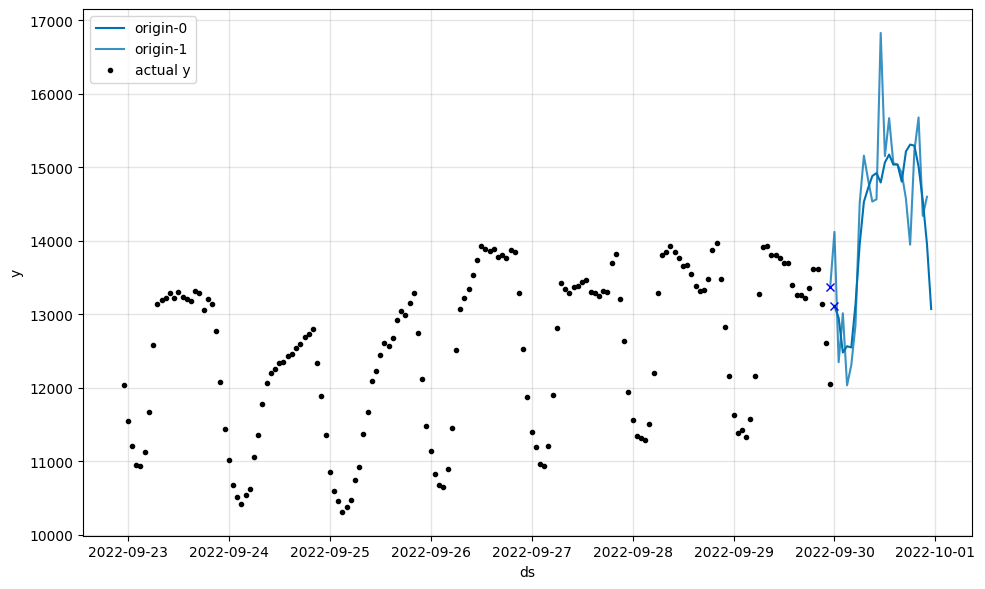

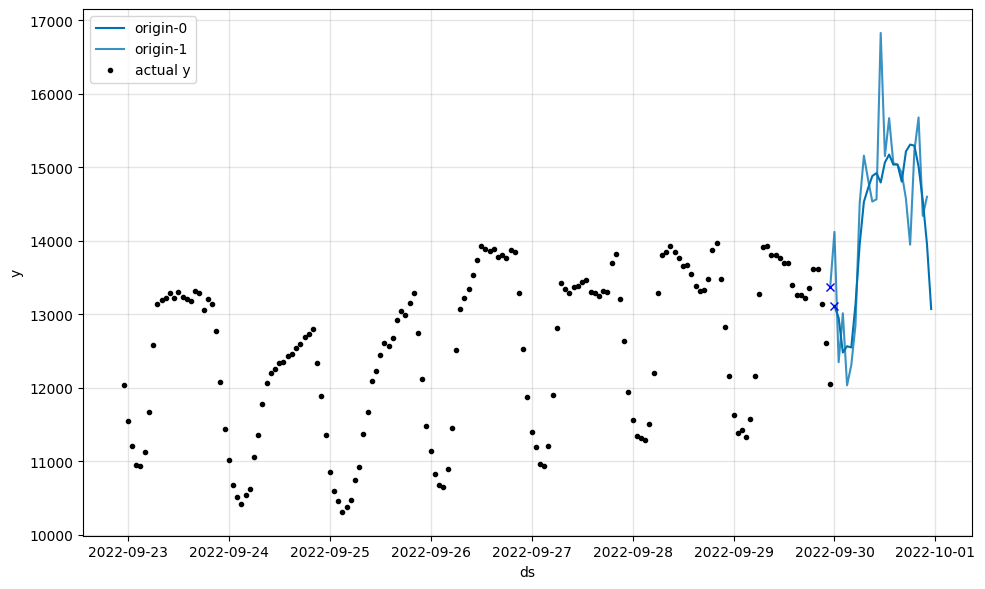

In [102]:
pred1 = model.predict(future)
model.plot(pred1)

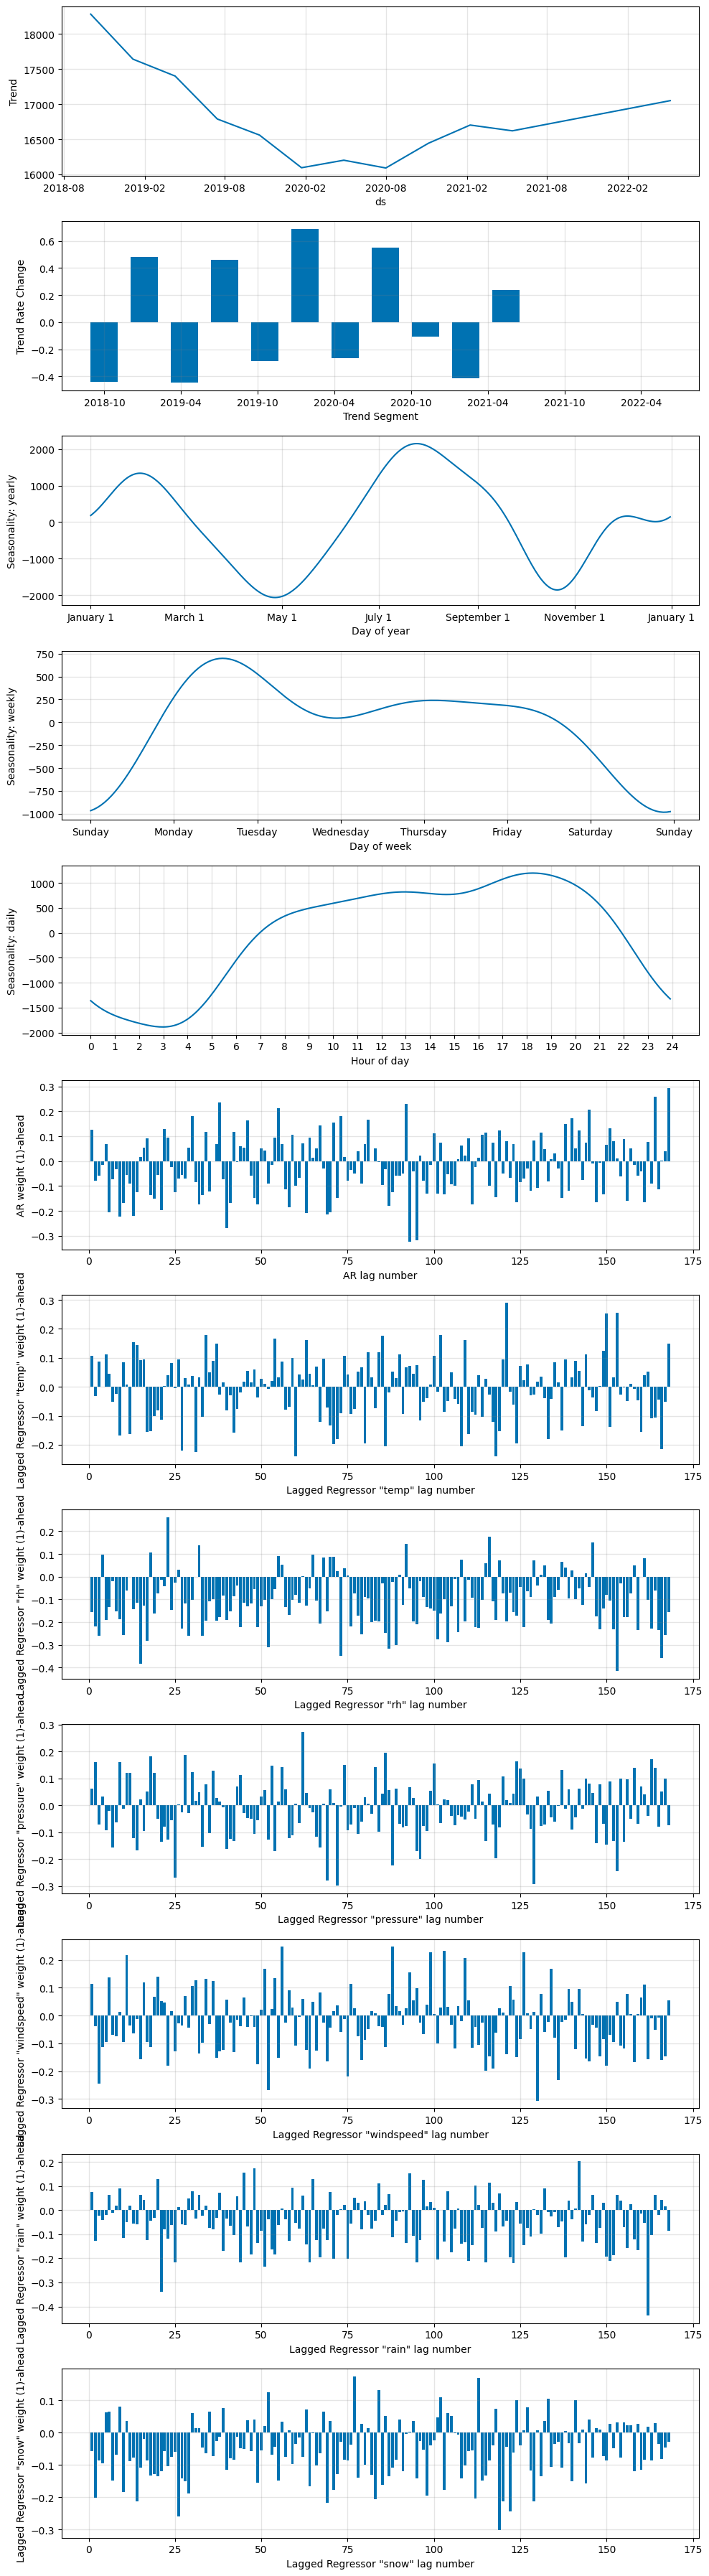

In [104]:
mp = model.plot_parameters()